# Variational Autoencoder

Autoencoders are neural network architectures used to:
* Encoder data - Create lower-dimension representations of input data.
* Decode data - From these lower-dimension representations, re-create the input data.

Variational autoencoders are a form of autoencoder that learns latent (lower-dimensional) *distribution* of inputs' mean and standard deviation. There is then a **sampling** layer after the latent encoding layer that samples from these mean and standard deviation distributions, outputting new, realistic synthetic observation.

In [723]:
# Commented out for non-Colab user

# # re upload files everytime run

# from google.colab import files

# uploaded = files.upload()

### Options

* `pass_only` - True if only want to generate normative data
* `scale` - True if want to scale all columns to (0,1) scale
* `multi-activation` - True if want output layer to have multiple activation functions
* `transform` - True if you want to transform columns to approximate normal distributions before going into the VAE
* `freqs_only` - True if you only want to produce frequencies and not other control variables
* `latent_dim` - Number of latent dimensions for the VAE

In [724]:
pass_only = True
scale = True
multi_activation = True
transform = False
freqs_only = False
latent_dim = 2

Adjustment

In [725]:
if freqs_only is True:
    if transform is True:
        transform = False
        print("Transform is set to True but this is not necessary as you are only producing frequencies, which are already between 0 and 1.\n ---> Setting transform to False")
    if multi_activation is True:
        multi_activation = False
        print("Multi_activation is set to True but this is not necessary as you are only producing frequencies, which are already between 0 and 1 - only need sigmoid function.\n ---> Setting multi_activation to False")


The best combination found was:
* `pass_only` = True
* `scale` = True
* `multi_activation` = True
* `transform` = False
* `freqs_only` = False

Even if we are looking to only produce frequencies, excluding the control variables seems to produce more sporadic results when we attempt generate only normative data (pass_only = True). The main hypothesis for this is that including the control variables in the generative model allows it to learn inherent relationships between absorbance values and various variables. This would not be captured if the control variables are not included in the generative model.

By including the control variables, scaling them to be between 0 and 1 before being encoded leads to much better results, even if their activation functions allow values outside that range. Having said so, setting multi_activation to True is still important, as using a sigmoid output activation for the control variables which can take values outside (0,1) leads to a gross over-generalisation, even after inverse scaling.

# Environment Set-up

## Libraries

In [726]:
## Load libraries

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
print('numpy: %s' % np.__version__)

# Deep learning
from tensorflow import concat
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)

from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K

# Plotting
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE
print('matplotlib: %s' % matplotlib.__version__)

import graphviz
print('graphviz: %s' % graphviz.__version__)

import plotly
import plotly.express as px
print('plotly: %s' % plotly.__version__)

import seaborn as sns

# Other
import sys
import os

main_dir=os.path.dirname(sys.path[0])
print('main dir: %s' % main_dir)

numpy: 1.22.3
Tensorflow/Keras: 2.9.0
matplotlib: 3.5.1
graphviz: 0.20.1
plotly: 5.10.0
main dir: /Users/benjamintan/Library/CloudStorage/OneDrive-TheUniversityofWesternAustralia/Master of Data Science/Year 2/Semester 2/CITS5553/CITS5553-Capstone-Project/Generative Models


## Loading Data

In [727]:
import pandas as pd

full_data = pd.read_csv('wba_data_CLEAN.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X = pd.concat([X_train, y_train], axis=1)
X_valid = pd.concat([X_test, y_test], axis=1)
full_data = full_data[X.columns]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(191, 120)
(191, 1)
(48, 120)
(48, 1)


In [728]:
# List of frequencies and control variables
freq_cols = [c for c in X.columns if c[:2] == "f("]
cont_cols = [c for c in X.columns if c[:2] != "f("]

## Pre-Processing

### Deleting Fail Observations

Delete all the 'failed' observations if the `pass_only` options is set to True.

In [729]:
if pass_only:
    X = X[X['OverallPoF'] == 0]
    X_valid = X_valid[X_valid['OverallPoF'] == 0]

    y_train = y_train[y_train['OverallPoF'] == 0]
    y_test = y_test[y_test['OverallPoF'] == 0]

### Column Re-Ordering

Re-ordering columns so that the relevant activations functions can be used on the relevant columns. They will be categorised, in order --  Variables which:
1. Lie on real number line (floating-point values that can be both positive and negative)
2. Can be any **positive** number (positive floating-point values)
3. Can only be within (0,1) range (including binary variables)

    * SC can only be positive
    * Gender, TympType, EarCoded, OverallPoF all binary
    * Frequencies' WBA values must lie between 0 and 1
    * The remaining variables lie on the real number line

The VAE is configure to automatically detect variables in this order and apply the activation functions accordingly.

In [730]:
# List of all control variables
cont_cols = [c for c in X.columns if c[:2] != "f("]

# List of all binary columns
bin_cols = ["Gender", "TympType", "Ear coded", "OverallPoF"]

pos_cols = ["SC", "ECV"]

# Remove binary columns from cont_cols
for bin_col in bin_cols:
    cont_cols.remove(bin_col)

for pos_col in pos_cols:
    cont_cols.remove(pos_col)

# Add them back at the end
cont_cols = cont_cols + pos_cols + bin_cols

# Re-order columns
X = X[cont_cols + freq_cols]
X_valid = X_valid[cont_cols + freq_cols]

X[cont_cols].head()

AgeY   TPP  OAE1  OAE1.4  OAE2  OAE2.8  OAE4  Pressure    SC   ECV  \
1   9.833333 -63.0   8.1    20.8  14.7     6.9   8.3        -4  1.32  0.81   
2  10.083333 -28.0  10.4    15.4  15.6     9.9  10.7         1  0.56  1.50   
3   8.666667   3.0  10.6    15.1  15.0     7.8   4.0        -4  1.07  1.15   
4   8.583333 -10.0   3.7    11.5   7.4     5.7   8.5        -3  0.43  1.03   
5   9.750000 -11.0  21.0    28.0  27.0    16.0  20.0        -3  0.56  0.95   

   Gender  TympType  Ear coded  OverallPoF  
1       1         0          0           0  
2       0         0          1           0  
3       1         0          0           0  
4       1         0          0           0  
5       0         0          1           0

### Data Transformation

We experiment with  transforming the distributions of variables to approximate normality.

VAEs use a Gaussian distribution to sample from. Although theoretically non-linear transformations of the decoder may be able to 'map' the normal distribution to other distributions, making distributions normal in the first place may yield performance improvements, especially because we are mapping so many variables to a significantly smaller number of latent distributions.

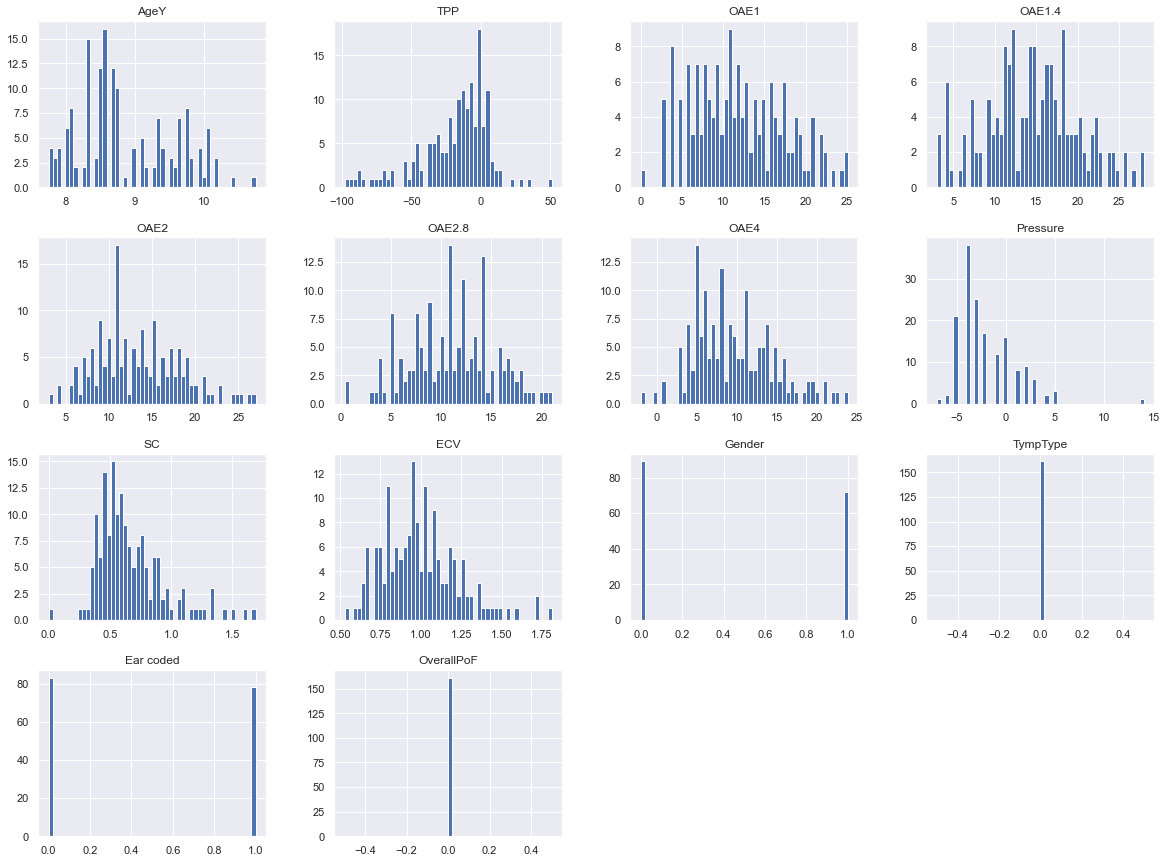

In [731]:
X[cont_cols].hist(bins=50, figsize=(20,15))
plt.show();

We can see that:
* TPP is left-skewed
* SC is right-skewed
* Pressure is right-skewed
* OAEs tend to be normally distributed 


Making copy of data to experiment with

In [732]:
# Experimental transformation functions
from math import exp
from math import log
from math import sqrt

# Making copy of dataframe to play around with
X_transformed = X.copy(deep=True)

#### Right Skewed

After manual experimentation, the following transformations made SC and Pressure approximate normal distributions:
* `SC`: Root 2
* `Pressure`: Root 4

/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


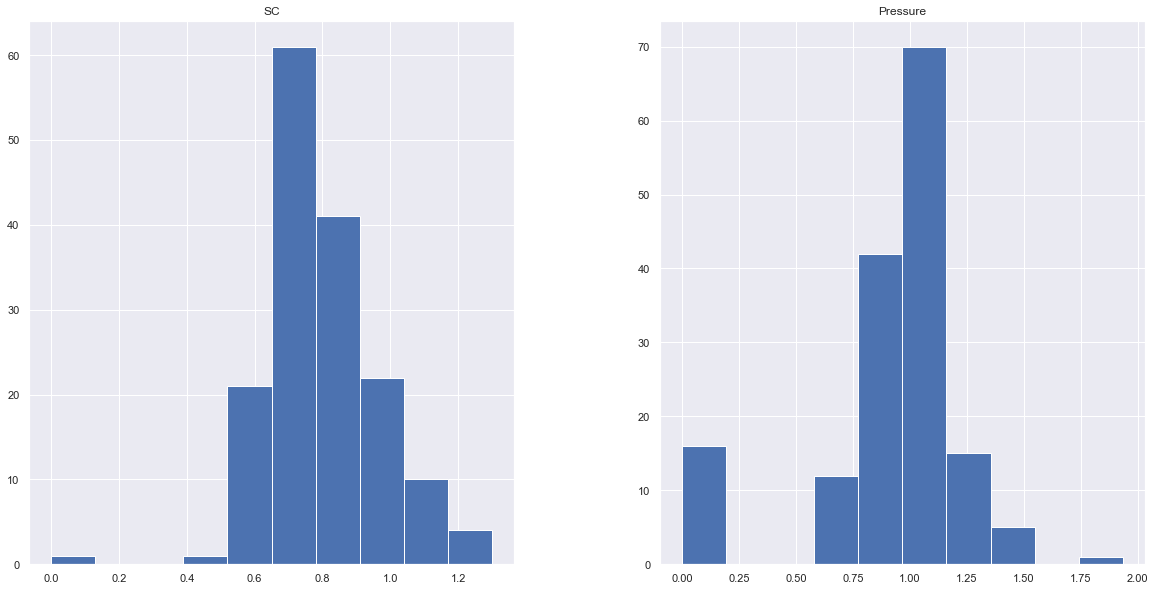

In [733]:
right_skewed = ['SC', 'Pressure']

X_transformed['SC'] = X['SC'].apply(lambda x: x**(1/2))
X_transformed['Pressure'] = X['Pressure'].apply(lambda x: x**(1/4))

X_transformed[right_skewed].hist();

#### Left Skewed

After manual experimentation, the best we could get was transforming `TPP` by root 4.

The result is not perfect but it is the best we can do given our constraints (e.g. cannot do log transformations due to the 0s).

/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


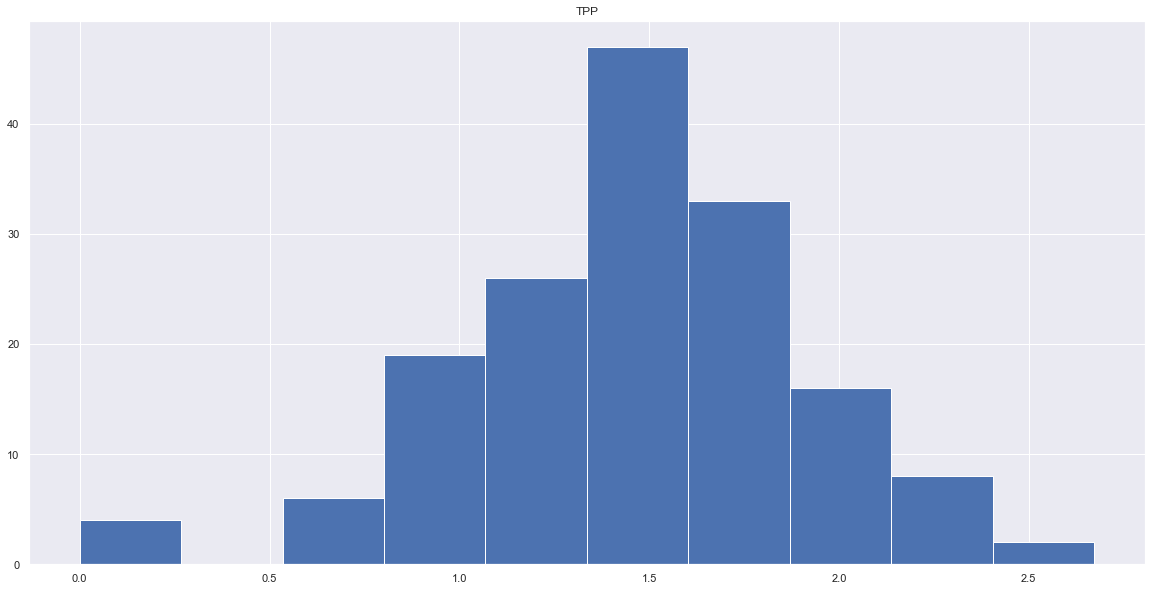

In [734]:
left_skewed = ['TPP'] # only done just in case any more left-skewed variables are added in the future

X_transformed['TPP'] = X['TPP'].apply(lambda x: x**(1/4))

X_transformed[left_skewed].hist();

#### Transformation Function

Based on the above results, we will create functions to transform and un-transform our data

(Be careful to not run multiple times!)

In [735]:
def normalise(df):
    """
    Transform data based on the above results
    """
    df['SC'] = df['SC'].apply(lambda x: x**(1/2))
    df['Pressure'] = df['Pressure'].apply(lambda x: x**(1/4))
    df['TPP'] = df['TPP'].apply(lambda x: x**(1/4))
    return df

def un_normalise(df):
    """
    Reverses the normalise function
    """
    df['SC'] = df['SC'].apply(lambda x: x**2)
    df['Pressure'] = df['Pressure'].apply(lambda x: x**4)
    df['TPP'] = df['TPP'].apply(lambda x: x**4)
    return df


#### Applying Transformation

Applying the above transformations if the `transformation` options is set to True.

In [736]:
if transform is True:
    X = normalise(X)
    X = normalise(X)

### Removing Non-Frequencies

Removing control variables if `freqs_only` option is set to True.

In [737]:
if freqs_only is True:
    X = X[freq_cols + ["OverallPoF"]]
    X_valid = X_valid[freq_cols + ["OverallPoF"]]

### Scaling

Scaling all data to (0,1) range if the option is set.

Neural networks work better with data all within this range. 

In [738]:
from sklearn.preprocessing import MinMaxScaler

if scale is True:
    # Scale all columns to (0,1) range
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X))
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_valid))
    X_train_scaled.columns = X.columns
    X_test_scaled.columns = X.columns
else:
    X_train_scaled = X.copy()
    X_test_scale = X_valid.copy()

# VAE

### Sampling Layer + Reparameterization Trick

The sampling layer samples from the distributions in the latent layer. However, this makes it difficult to train the network using backpropagation. Backpropagation involves calculating the change in error/loss function with respect to changes in model weights. However, this layer involves *sampling* from distributions in the previous layer and the 'randomness' of sampling means that the aforementioned differentiation cannot be calculated. This makes the sampling layer a 'blockage' to backpropagation.\
\
To tackle this, the **reparameterization trick** is used. By making the latent vector $\mu + \sigma * \epsilon$ (i.e., multiplying $\sigma$ by $\epsilon$), where $\epsilon$ ~ Norm(0,1), a neuron is added to the sampling layer which allows backpropagation to continue through previous layers. 

In [739]:
def sampling(args):
  """
  This funciton conducts the reparameterization trick for the sampling layer
  """
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.) ## reparameterisation trick
  return z_mean + K.exp(z_log_sigma) * epsilon

### Encoder

The encoder takes in an *n*-dimensional input and reduces it to (`latent_dim`) latent dimensions.

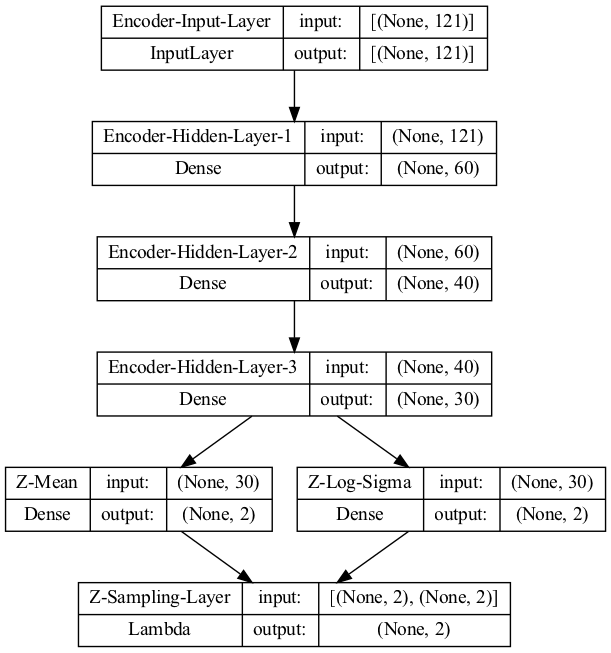

In [740]:
## Encoder
original_dim = len(X_train_scaled.columns)

# latent_dim = 2

visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

h_enc1 = Dense(units=original_dim//2, activation='selu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=original_dim//3, activation='selu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=original_dim//4, activation='selu', name='Encoder-Hidden-Layer-3')(h_enc2)

z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])

encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=100)

### Decoder

The decoder re-constructs (a variant of, in this case) the initial input, by sampling from the mean and standard deviation distributions in the latent layer.

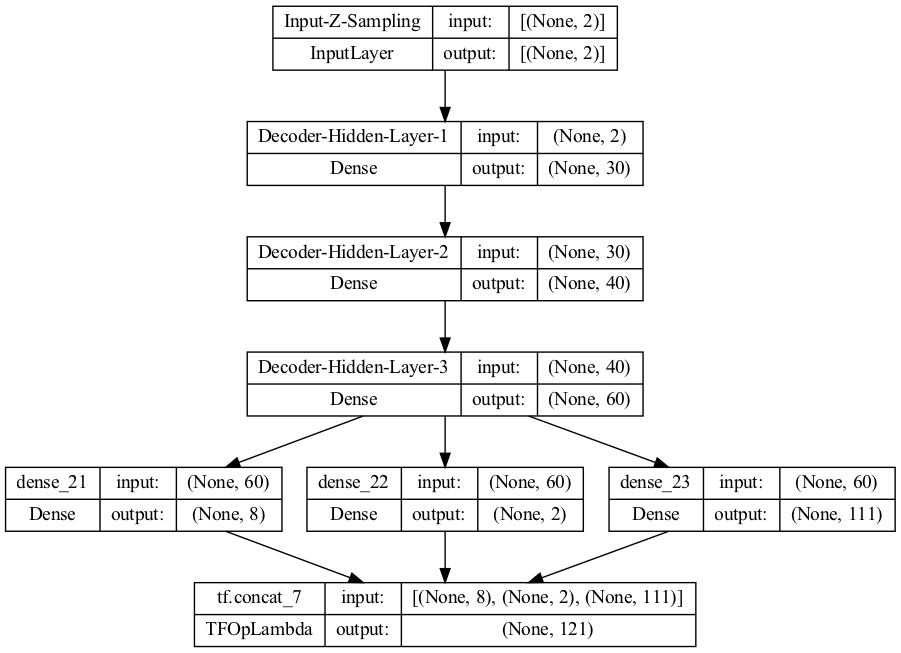

In [741]:
## Decoder
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

h_dec = Dense(units=original_dim//4, activation='selu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=original_dim//3, activation='selu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=original_dim//2, activation='selu', name='Decoder-Hidden-Layer-3')(h_dec2)

## Multi output activation
# Linear for control variables who can take any value
# Softplus for control variables whocan take any POSITIVE value
# Sigmoid for binary variables, frequencies and any other variables that lie between 0 and 1.
if multi_activation:
    # No activation (all non-positive-only and non-binary control variables)
    output_1 = Dense(units = len(cont_cols) - len(pos_cols) - len(bin_cols), activation=None)(h_dec3)

    # SoftPlus (positive values only, any range) 
    output_2 = Dense(units = len(pos_cols), activation='softplus')(h_dec3)

    # Sigmoid (binonmial + frequencies)
    output_3 = Dense(units = len(bin_cols) + len(freq_cols), activation='sigmoid')(h_dec3)

    # Combining into one layer
    outputs = concat([output_1, output_2, output_3], axis=1)
##
else:
# Single output activation
    outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=100)

In [742]:
## Autoencoder

# Reference -- From above:
### visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

outpt = decoder(
    encoder(visible)[2] # Encode the input and take the 3rd element of the output (z-score)
    )

# Set mode parameters (number of inputs/outputs)
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

### Loss Function

We use mean-squared error loss (i.e., mean squared difference between encoder input and decoder output).

**KL-Divergence**\
As variational autoencoders sample from distributions with, in this case, the goal of generating *new* samples, the loss function needs to be altered for that goal. In other words, we don't want the output to be exactly the same as the input - we want features of the output to come from the same distributions as features from the input, such that the output is a realistic synthetic observation that can be used for analysis.\
Thus, we add a *Kullback-Leibler (KL) Divergence* term, which calculates the difference between **probability distributions**. 

In [743]:
## Loss Function
r_loss = original_dim * keras.losses.mse(visible, outpt) # MSE loss
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1) # KL Divergence
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### Model Training

Epoch 1/25
11/11 [==============================] - 1s 70ms/step - loss: 16.0964 - val_loss: 11.3889
Epoch 2/25
11/11 [==============================] - 1s 55ms/step - loss: 9.9215 - val_loss: 11.1401
Epoch 3/25
11/11 [==============================] - 1s 58ms/step - loss: 8.5952 - val_loss: 9.5550
Epoch 4/25
11/11 [==============================] - 0s 37ms/step - loss: 7.8013 - val_loss: 9.1360
Epoch 5/25
11/11 [==============================] - 0s 37ms/step - loss: 7.0603 - val_loss: 10.2010
Epoch 6/25
11/11 [==============================] - 0s 32ms/step - loss: 6.2443 - val_loss: 8.9990
Epoch 7/25
11/11 [==============================] - 0s 31ms/step - loss: 5.6896 - val_loss: 10.2358
Epoch 8/25
11/11 [==============================] - 0s 26ms/step - loss: 5.5594 - val_loss: 9.2199
Epoch 9/25
11/11 [==============================] - 0s 27ms/step - loss: 7.0348 - val_loss: 8.4506
Epoch 10/25
11/11 [==============================] - 0s 25ms/step - loss: 5.3018 - val_loss: 8.3140
Epoc

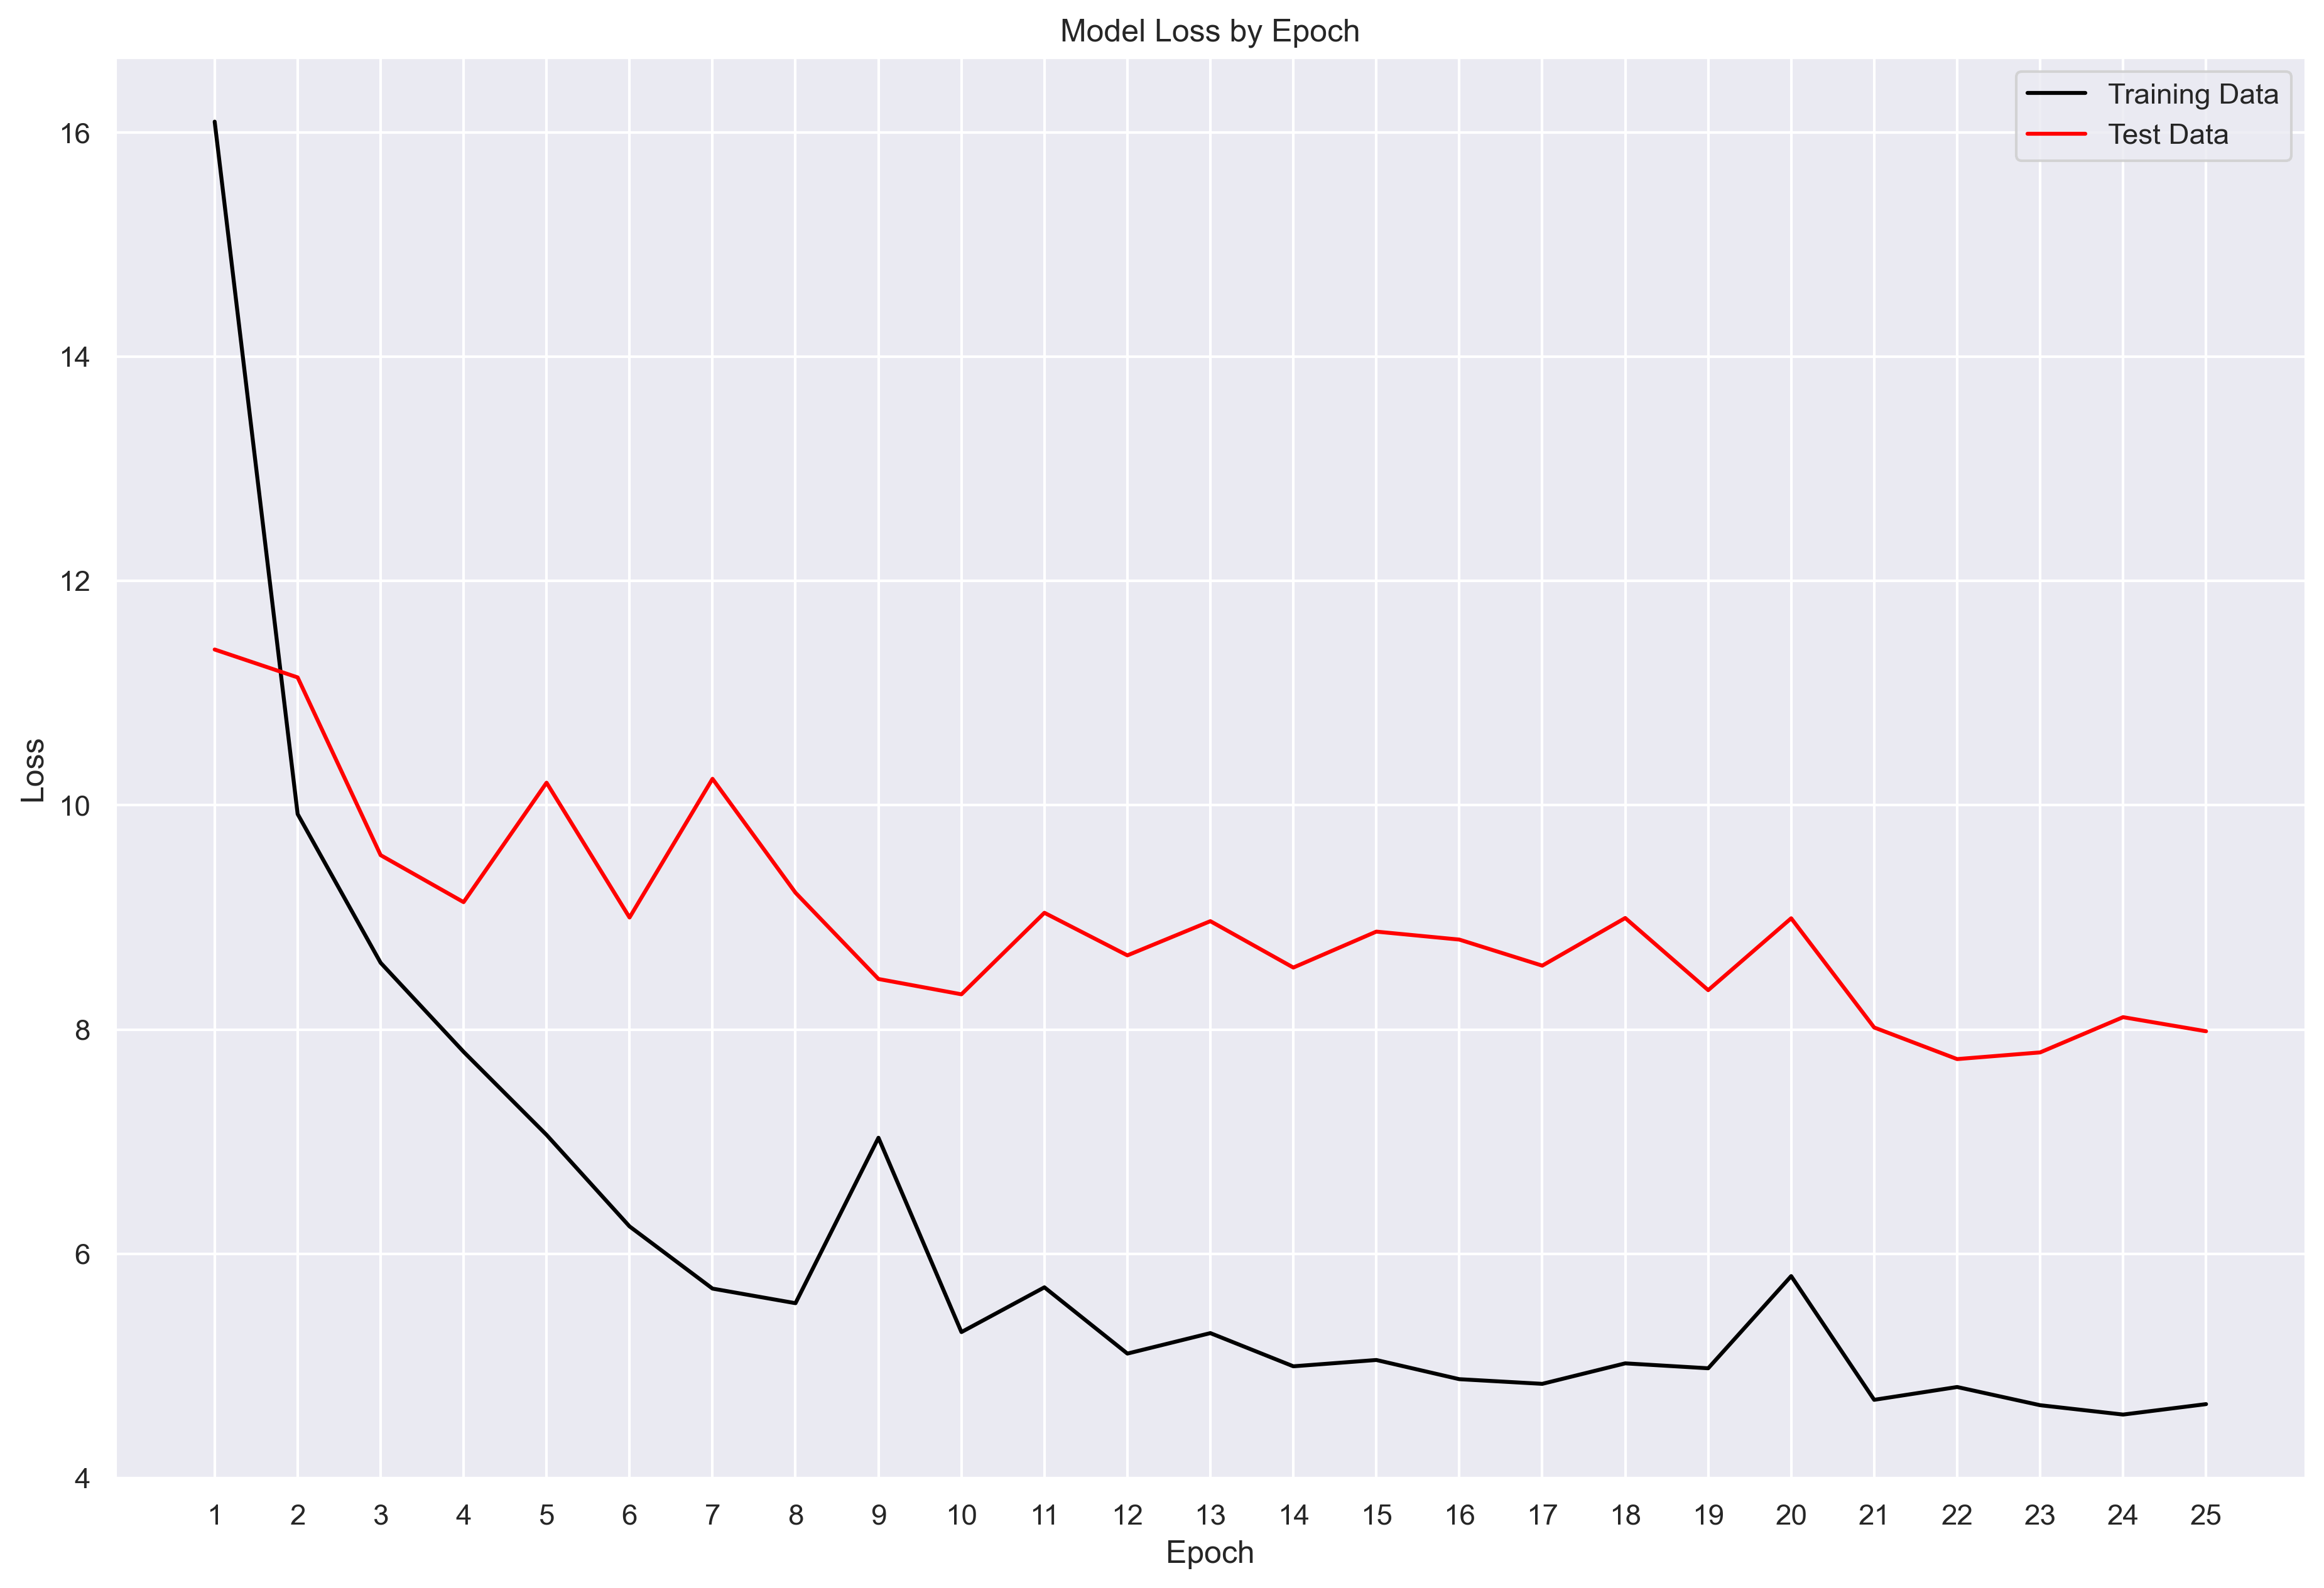

In [744]:
# Model fit
history = vae.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=16, validation_data=(X_test_scaled, X_test_scaled))

sns.set(rc={'figure.figsize':(20,10)})

# Plot loss over time
fig, ax = plt.subplots(figsize=(15,10), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1));
plt.legend()
plt.show();

### Visualising (2) Latent Dimensions

2/2 [==============================] - 0s 17ms/step


/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


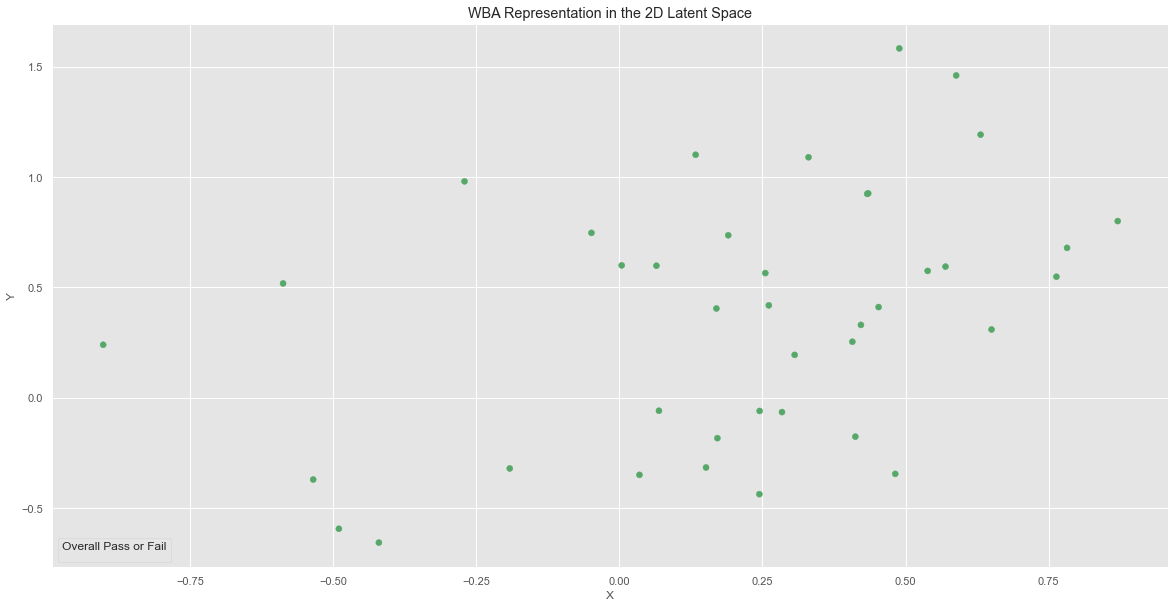

In [745]:
if latent_dim == 2:
    ## Visualise Latent Space
    plt.style.use('ggplot')

    X_test_encoded = encoder.predict(X_test_scaled)

    colours = {
        1:"r",
        0:"g"
    }

    fig, ax = plt.subplots()
    # encoder returns 3 arrays, z-mean, z-log-sigma, z 
    scatter = ax.scatter(
                        X_test_encoded[0][:,0],
                        X_test_encoded[0][:,1],
                        c=y_test['OverallPoF'].map(colours)
                        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("WBA Representation in the 2D Latent Space")
    ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
    plt.show()
else:
    print("Cannot visualise latent space for >2 dimensions.\nNumber of dimensions: {}.".format(latent_dim))

Printing sample

In [746]:
if latent_dim == 2:
    ## Generate from latent space
    z_sample = [[-1.8,-0.3]]
    wba_decoded = decoder.predict(z_sample)
    wba_decoded[0]

1/1 [==============================] - 0s 64ms/step


## Generating Samples from VAE

With the trained VAE, we generate samples. To do this, we generate random numbers (normally distributed with $\mu = 0$, $\sigma = 1$) to map to each latent dimension (distribution). These numbers are used to sample from the latent distributions.

`z_sample` will be a list of lists, with each embedded list having the same number of elements as the number of latent dimensions.

In [747]:
from random import seed
from random import random
from numpy.random import normal

seed(1)

n_samples = 10000
z_sample = []
z_range = 3

for _ in range(n_samples):
  sample = []
  for _ in range(latent_dim):
    sample.append(normal(0,1))
  z_sample.append(sample)

Using the values from `z_sample` to select values from the latent distributions (i.e., generating observations).

In [748]:
# Generate synthetic observations
wba_decoded = decoder.predict(z_sample)

# Convert to dataframe
wba_decoded = pd.DataFrame(wba_decoded, columns = X_train_scaled.columns)

313/313 [==============================] - 2s 5ms/step


### Pre-Preprocessing Reversal

Reversing the normalisation of distirbutions and MinMaxScaler

In [749]:
# Reverse the transformation pre-processing (un-normalisation of distirbutions)
if transform:
    wba_decoded = un_normalise(wba_decoded)

# Reversing MinMaxScaler
if not freqs_only:
    unscaled = scaler.inverse_transform(wba_decoded)
else:
    unscaled = wba_decoded

# Converting to dataframe
gen_df = pd.DataFrame(unscaled, columns = X_train_scaled.columns)

Rounding binary variables to closest whole number.

Binary variables' values can be interpreted as probabilities of having the value of 1 as the neural network maps these values to log likelihoods followed by sigmoid functions.

In [750]:
if not freqs_only:
    for bin_col in bin_cols:
        gen_df[bin_col] = round(gen_df[bin_col])

# Generated Data Assessment

Creating variables to give information to plot titles

In [751]:
if pass_only:
    cond_pass = "Normative Only"
else:
    cond_pass = "Normative + Anomalous"

## Making Long Format

Making long-format dataframes with only frequency variables, for visualisation.

In [752]:
if pass_only:
    gen_freqs_long = gen_df[freq_cols].copy(deep=True)
    gen_freqs_long = gen_freqs_long.melt()

    freqs_long = full_data[freq_cols + ['OverallPoF']].melt('OverallPoF')
    # freqs_long = freqs_long[freqs_long['OverallPoF'] == 0]

    gen_freqs_long.columns = ['Frequency', 'Absorbance']
    freqs_long.columns = ['OverallPoF', 'Frequency', 'Absorbance']


else:
    gen_freqs_long = gen_df[freq_cols + ['OverallPoF']].copy(deep=True)
    gen_freqs_long = gen_freqs_long.melt(['OverallPoF'])
    freqs_long = full_data[freq_cols + ['OverallPoF']].melt('OverallPoF')

    gen_freqs_long.columns = ['OverallPoF', 'Frequency', 'Absorbance']
    freqs_long.columns = ['OverallPoF', 'Frequency', 'Absorbance']


## Frequency Distribution Comparison

### Generated Data

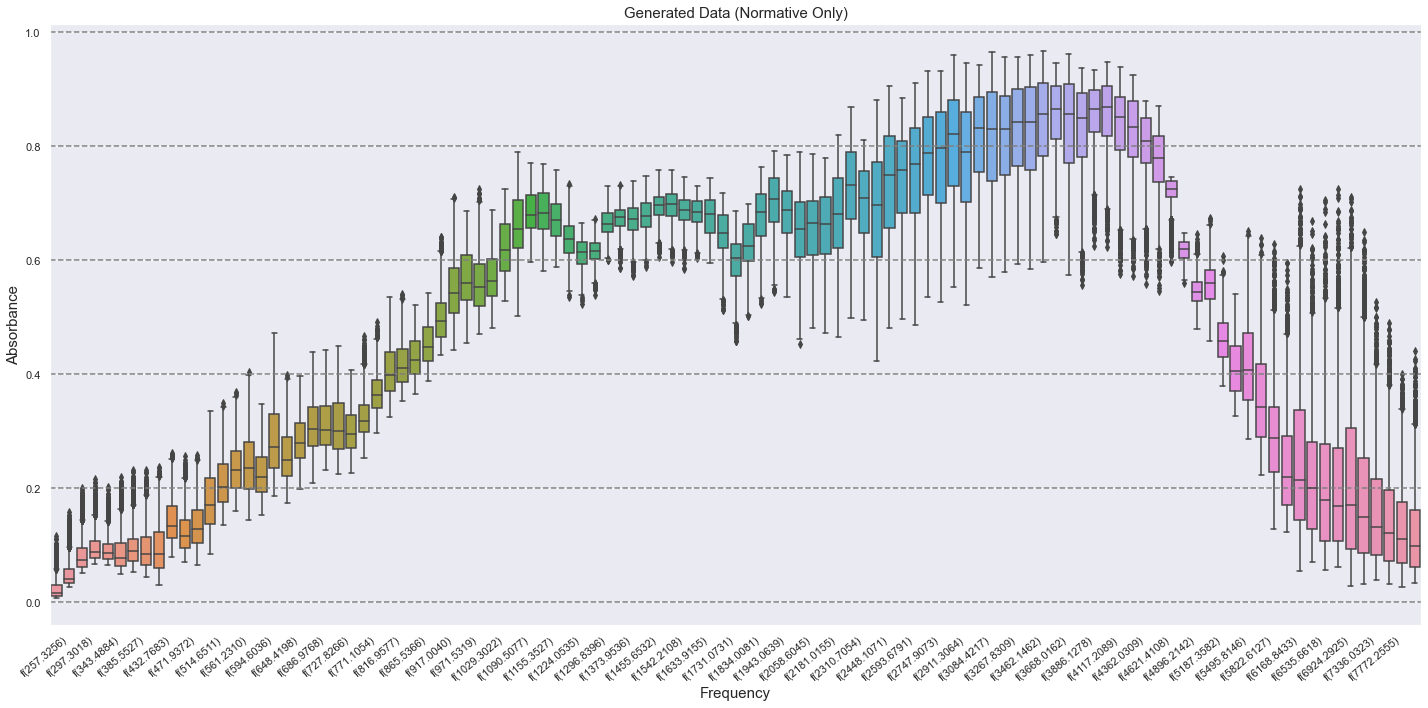

In [753]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="Absorbance", data=gen_freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.axes.set_title('Generated Data ({})'.format(cond_pass), fontsize=15)
ax.set_xlabel("Frequency", fontsize=15)
ax.set_ylabel("Absorbance",fontsize=15)

ax.axhline(1.0, ls='--', color='grey')
ax.axhline(0.8, ls='--', color='grey')
ax.axhline(0.6, ls='--', color='grey')
ax.axhline(0.4, ls='--', color='grey')
ax.axhline(0.2, ls='--', color='grey')
ax.axhline(0.0, ls='--', color='grey')

sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

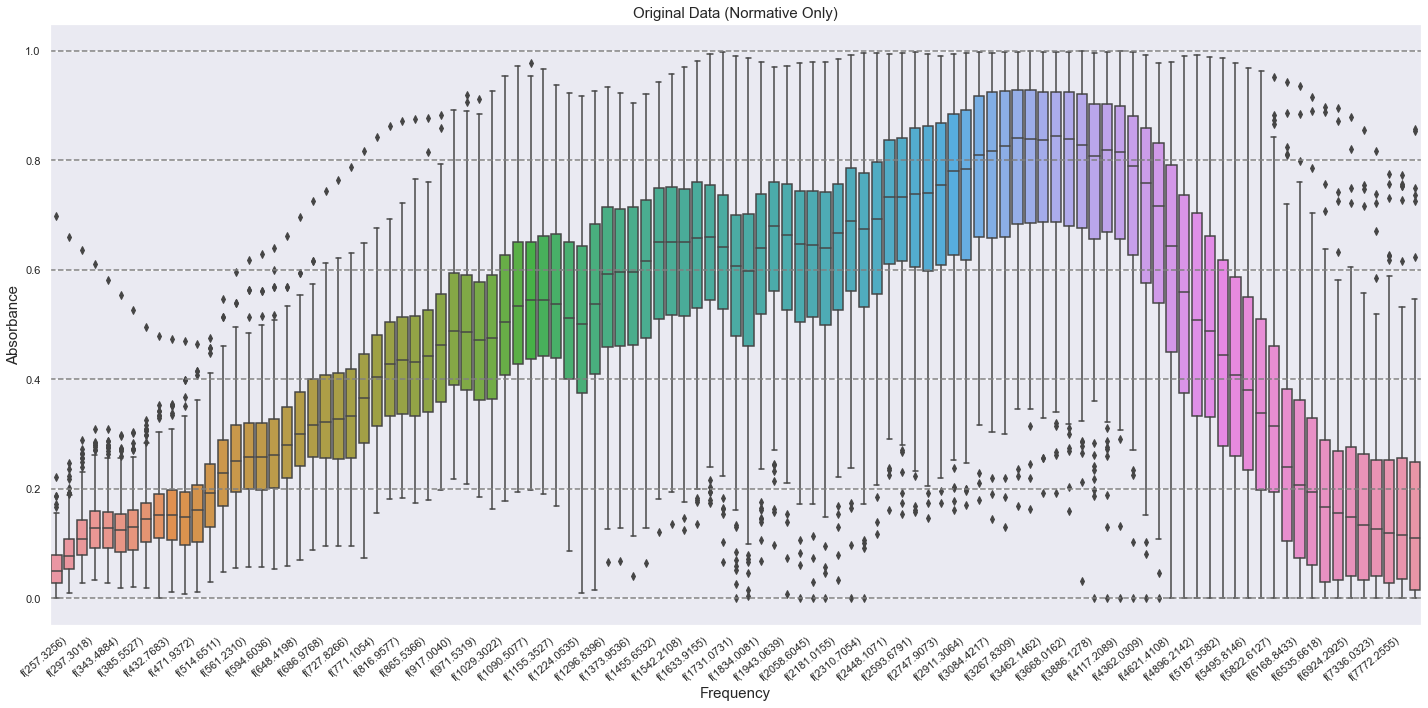

In [754]:
sns.set(rc={'figure.figsize':(20,10)})
# sns.set(font_scale=2)
ax = sns.boxplot(x="Frequency", y="Absorbance", data=freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.axes.set_title('Original Data ({})'.format(cond_pass), fontsize=15)
ax.set_xlabel("Frequency", fontsize=15)
ax.set_ylabel("Absorbance",fontsize=15)

ax.axhline(1.0, ls='--', color='grey')
ax.axhline(0.8, ls='--', color='grey')
ax.axhline(0.6, ls='--', color='grey')
ax.axhline(0.4, ls='--', color='grey')
ax.axhline(0.2, ls='--', color='grey')
ax.axhline(0.0, ls='--', color='grey')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

## Pass/Fail Distribution Comparison

### Generated Data

<ipython-input-755-f45354a000e0>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


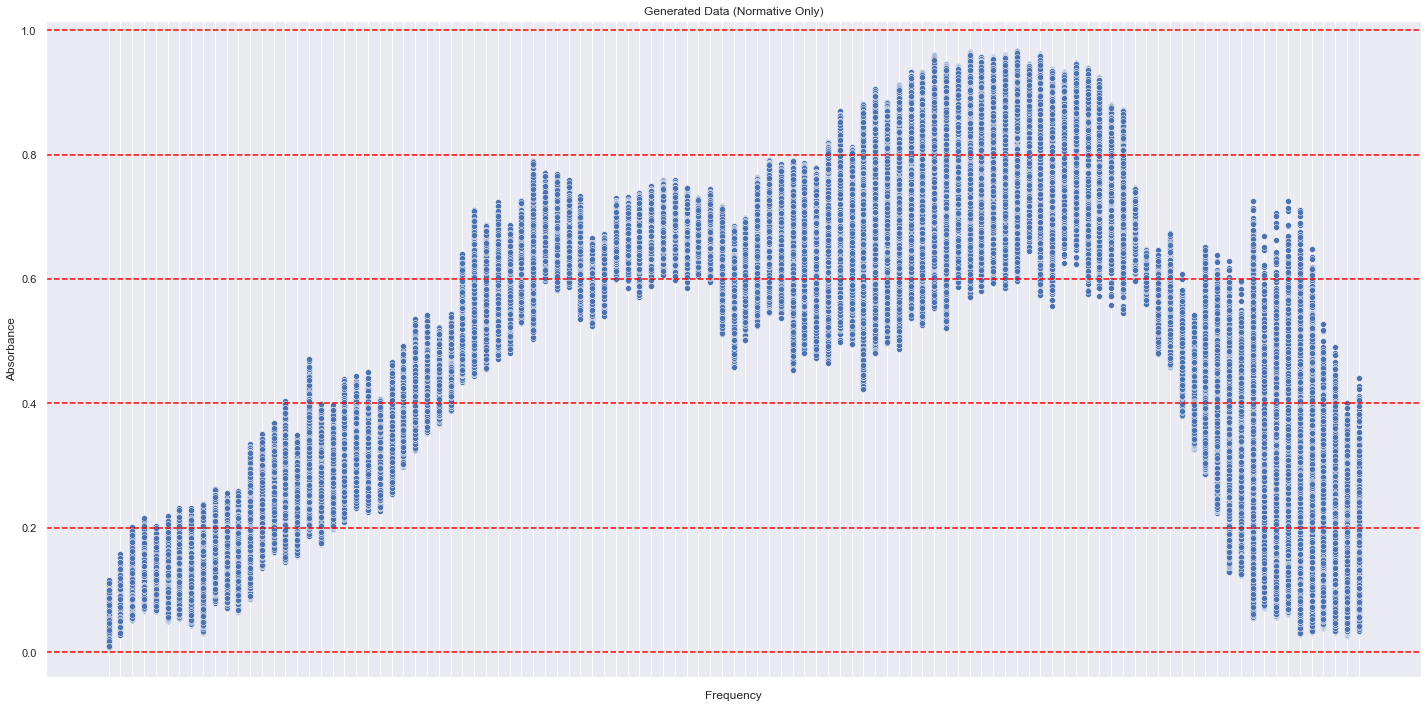

In [755]:
if not pass_only:
    ax = sns.scatterplot(data = gen_freqs_long, x='Frequency', y='Absorbance', hue='OverallPoF')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Data ({})".format(cond_pass))
else:
    ax = sns.scatterplot(data = gen_freqs_long, x='Frequency', y='Absorbance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Data ({})".format(cond_pass))

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

<ipython-input-756-1155f6649a9d>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


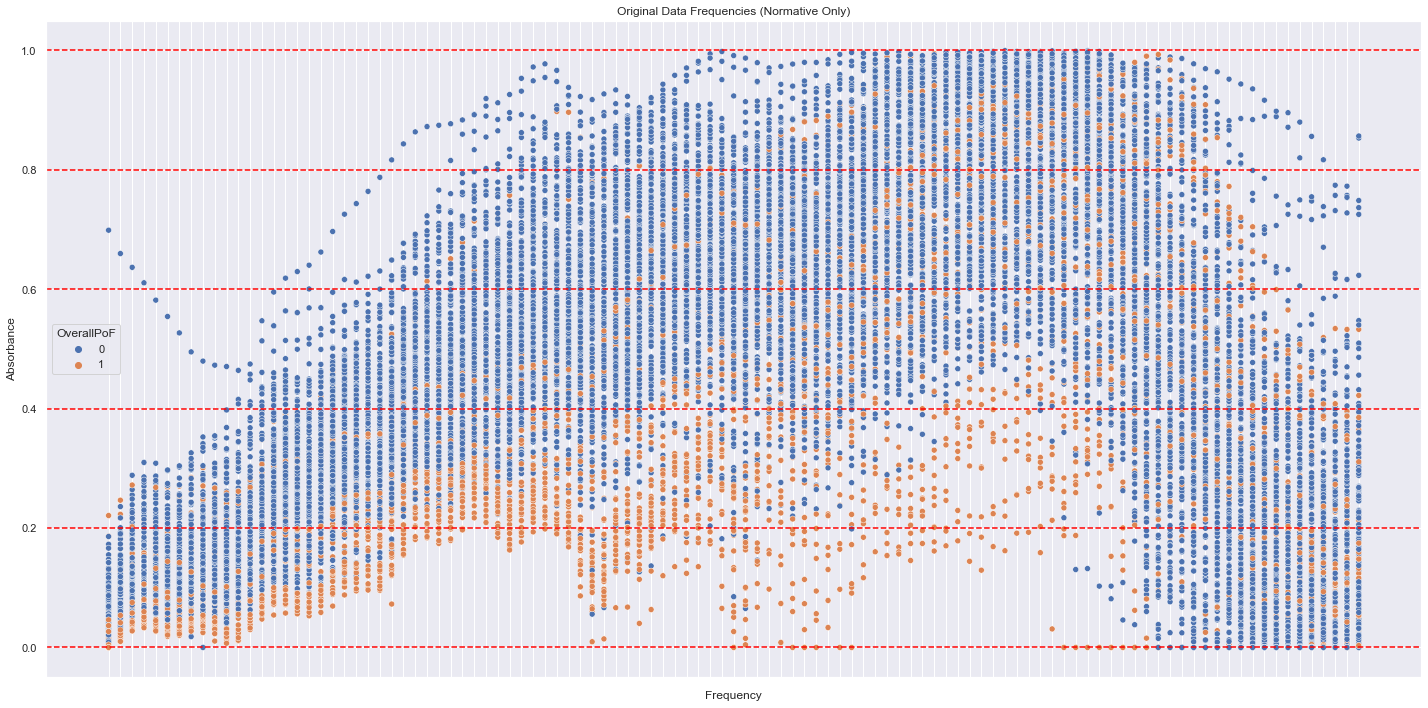

In [756]:
ax = sns.scatterplot(data = freqs_long, x='Frequency', y='Absorbance', hue='OverallPoF')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Original Data Frequencies ({})".format(cond_pass))

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

Class counts comparison

In [757]:
if not pass_only:
    print(gen_df['OverallPoF'].value_counts())

In [758]:
print(full_data['OverallPoF'].value_counts())

0    201
1     38
Name: OverallPoF, dtype: int64


## Comparing Control Variables

### Numerical Summaries

In [759]:
if not freqs_only:
    gen_df[cont_cols].describe()

In [760]:
if not freqs_only:
    X[cont_cols].describe()

### Histograms

In [761]:
cont_cols_plot = [c for c in cont_cols if c not in ['Gender', 'TympType', 'Ear coded', 'OverallPoF']]

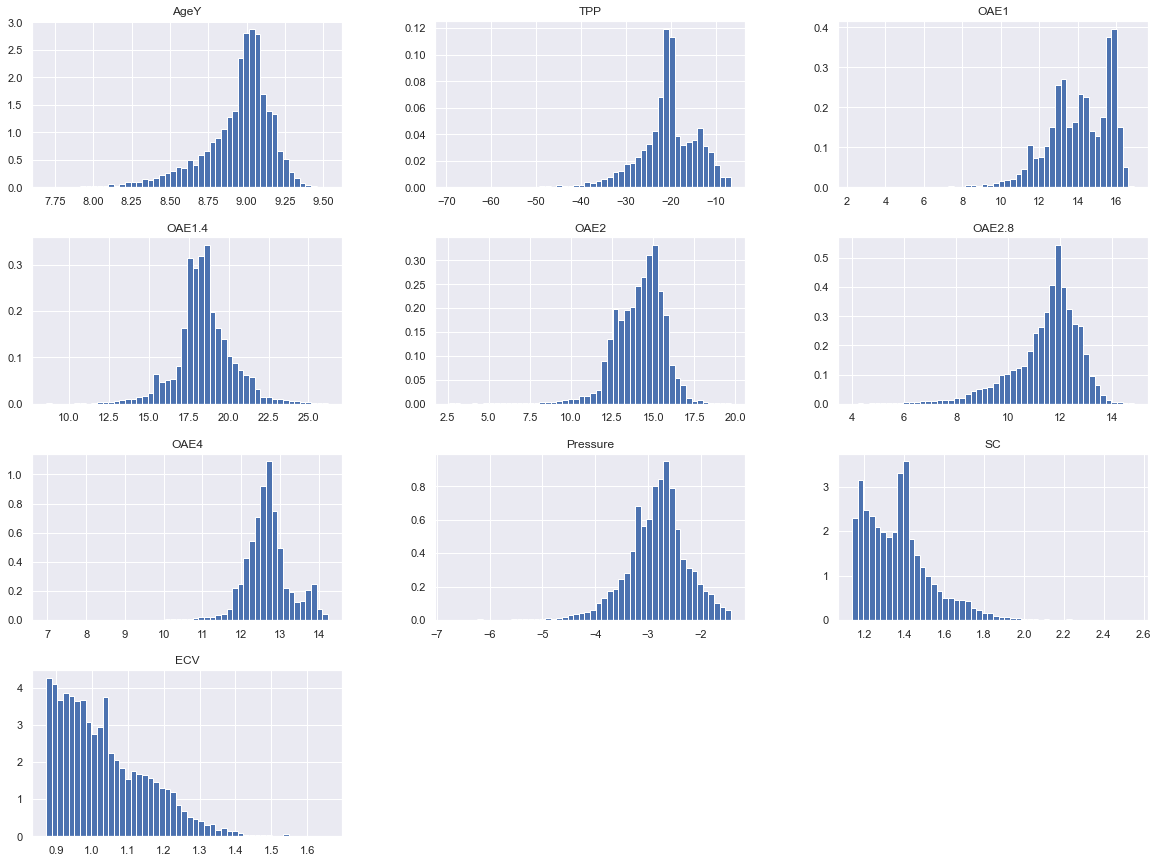

In [762]:
if not freqs_only:
    gen_df[cont_cols_plot].hist(bins=50, figsize=(20,15), rwidth=2, density=True)
    plt.show();

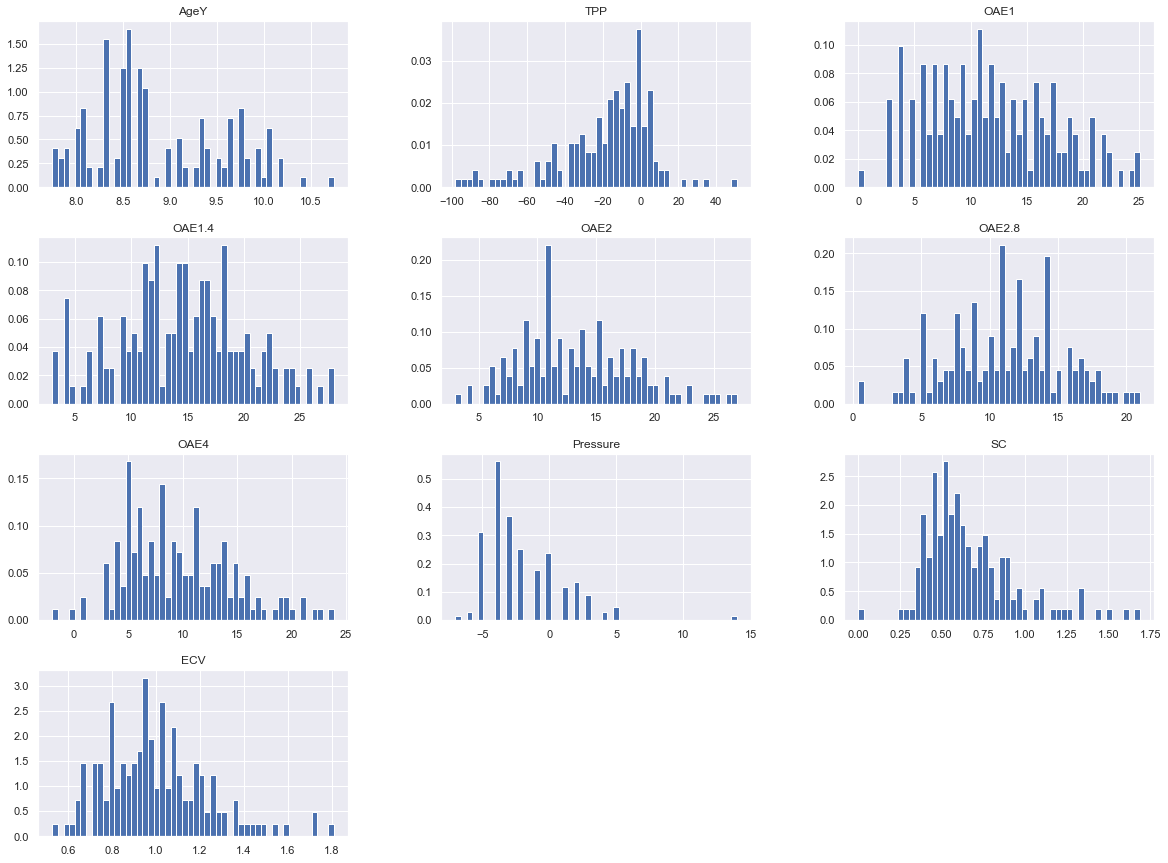

In [763]:
if not freqs_only:
    if pass_only:
        X[X['OverallPoF']==0][cont_cols_plot].hist(bins=50, figsize=(20,15), density = True)
    else:
        X[cont_cols_plot].hist(bins=50, figsize=(20,15))
    plt.show();

(array([[2.23350567e-01, 3.65482746e-01, 9.34011462e-01, 4.67005731e-01,
         2.23350567e-01, 3.24873552e-01, 3.45178149e-01, 2.84264358e-01,
         8.12183880e-02, 2.03045970e-02],
        [1.11147364e-02, 5.85158181e-02, 2.35370888e-01, 7.86204148e-01,
         2.00522921e+00, 1.72278414e-01, 3.26904012e-04, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00]]),
 array([ 7.69099808,  7.99689827,  8.30279846,  8.60869865,  8.91459885,
         9.22049904,  9.52639923,  9.83229942, 10.13819962, 10.44409981,
        10.75      ]),
 <a list of 2 list[Polygon] objects>)

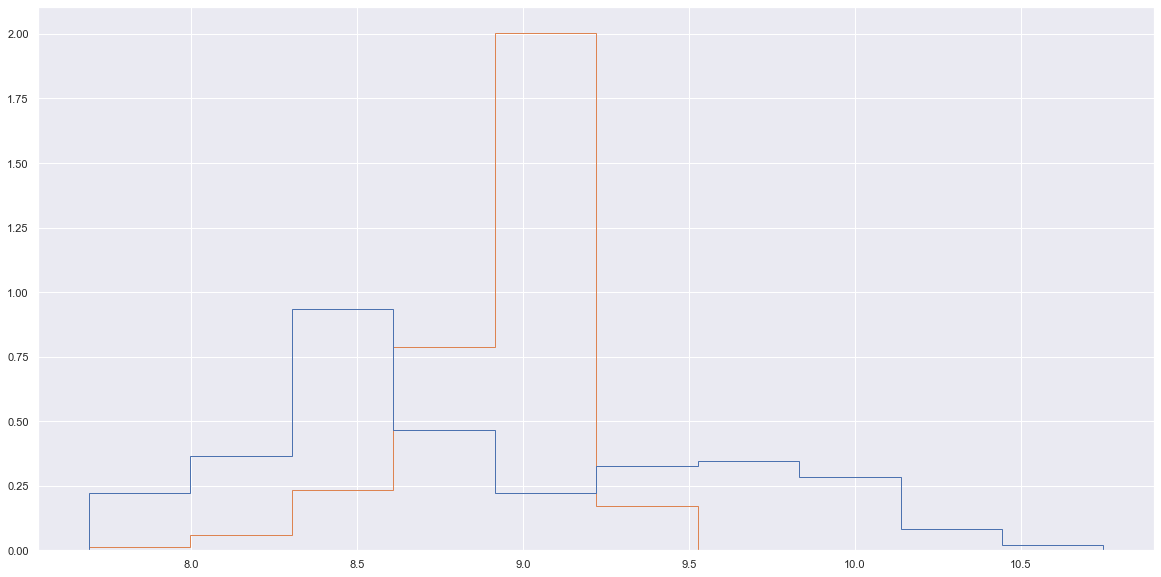

In [764]:
# gen_df[cont_cols_plot].hist(bins=50, figsize=(20,15), rwidth=2, density=True, orientation = 'vertical', stacked = True)
# X[X['OverallPoF']==0][cont_cols_plot].hist(bins=50, figsize=(20,15), density = True)
# plt.show();

plt.hist([X[X['OverallPoF']==0]['AgeY'],gen_df['AgeY']],
            density = True, alpha = 1, histtype='step')

(array([[3.30253390e-05, 3.30253390e-05, 3.30253390e-05, 6.60506780e-05,
         3.30253390e-05, 0.00000000e+00, 3.30253390e-05, 3.30253390e-05,
         3.30253390e-05, 6.60506780e-05, 3.30253390e-05, 6.60506780e-05,
         0.00000000e+00, 0.00000000e+00, 9.90760171e-05, 3.30253390e-05,
         9.90760171e-05, 1.65126695e-04, 6.60506780e-05, 0.00000000e+00,
         1.65126695e-04, 1.65126695e-04, 1.98152034e-04, 1.32101356e-04,
         1.32101356e-04, 2.64202712e-04, 1.65126695e-04, 3.30253390e-04,
         3.63278729e-04, 2.97228051e-04, 3.96304068e-04, 2.31177373e-04,
         5.94456102e-04, 2.31177373e-04, 3.63278729e-04, 9.90760171e-05,
         6.60506780e-05, 6.60506780e-05, 0.00000000e+00, 0.00000000e+00,
         3.30253390e-05, 0.00000000e+00, 3.30253390e-05, 0.00000000e+00,
         3.30253390e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 3.30253390e-05],
        [3.30253390e-05, 3.30253390e-05, 3.30253390e-05, 6.60506780e-05,
         

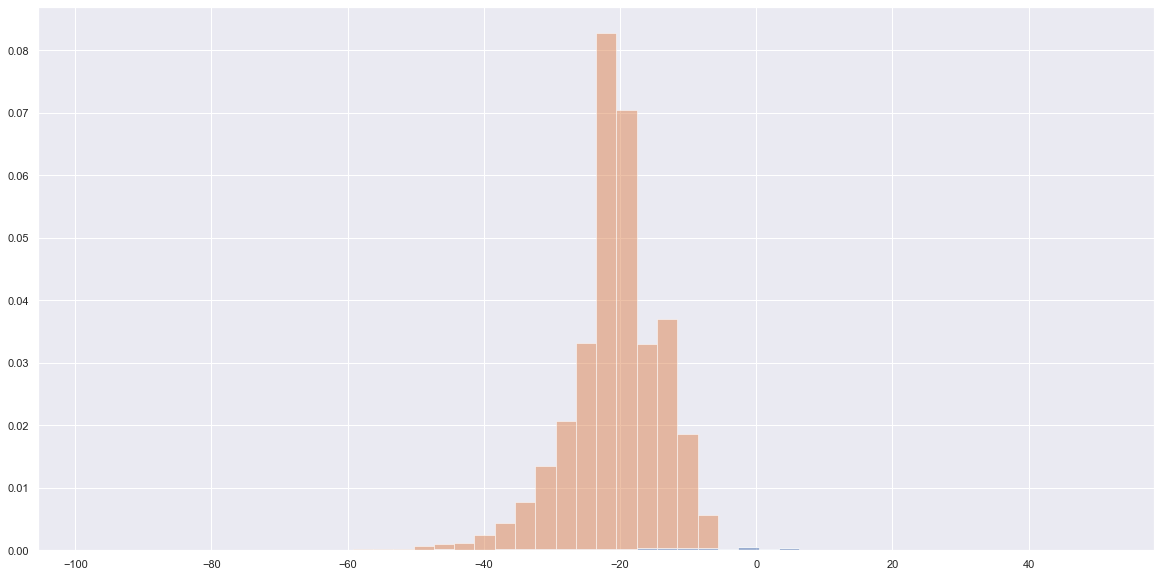

In [765]:
plt.hist([
        X[X['OverallPoF']==0]['TPP'], gen_df['TPP']
    ],
    density = True,
    stacked=True,
    alpha = 0.5,
    bins=50)

### Creating Balanced Dataframe

Dataframe with the same number of passes and fails.

Commented out by default.\
Uncomment if want to produce a balanced generated dataset, but need to produce a higher number of samples (probably 50000-100000)


In [766]:
# # Rounding DOWN to the nearest 1000 fail observations (e.g. round 2600 down to 2000)
# nearest_1000_down = gen_df['OverallPoF'].value_counts()[1]-gen_df['OverallPoF'].value_counts()[1]%1000

# # Balanced DF consists of `nearest_1000_down` pass and fail observations
# gen_df_balanced = gen_df.groupby('OverallPoF').apply(lambda x: x.sample(nearest_1000_down))

Confirm that distributions are still representative of population

In [767]:
# gen_df_balanced[cont_cols].hist(bins=50, figsize=(20,15))

Splitting into training and test set

In [768]:
# X_gen = gen_df_balanced[cont_cols + freq_cols]
# y_gen = gen_df_balanced['OverallPoF']

In [769]:
# X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_gen, y_gen, test_size=0.1, random_state=1337, stratify=y_gen)

In [770]:
# X_gen_train.to_csv("./X_gen_train.csv")
# X_gen_test.to_csv("./X_gen_test.csv")
# y_gen_train.to_csv("./y_gen_train.csv")
# y_gen_test.to_csv("./y_gen_test.csv")

In [771]:
# gen_df_long.to_csv("gen_df_long.csv")

# Anomaly Detection

For this section, change the `pass_only` option at the top to TRUE.

## Normative Range

### Visualisation

In [772]:
gen_df_normative = gen_df[gen_df['OverallPoF'] == 0]

minmax_dict = {}

for freq in freq_cols:
    minmax_dict[freq] = []

    min_freq = min(gen_df[freq])
    max_freq = max(gen_df[freq])

    minmax_dict[freq].append(min_freq)
    minmax_dict[freq].append(max_freq)

normative_df = pd.DataFrame(minmax_dict).T
normative_df['freq'] = normative_df.index
normative_df.columns = ['Lower Limit', 'Upper Limit', 'freq']

In [773]:
normative_df_long = normative_df.melt(['freq'])
normative_df_long.columns = ['Frequency','Limit','Absorbance']

In [774]:
normative_df.head()

Lower Limit  Upper Limit         freq
f(226.0000)     0.007547     0.116541  f(226.0000)
f(257.3256)     0.026797     0.158379  f(257.3256)
f(280.6155)     0.051779     0.201512  f(280.6155)
f(297.3018)     0.066962     0.216037  f(297.3018)
f(324.2099)     0.065935     0.203293  f(324.2099)

### Anomaly Detection

In [775]:
from sklearn.metrics import accuracy_score
def norm_range(df, norm_df, leeway = 0.1, freqs="all"):
    true = df['OverallPoF'].to_list()
    pred = [0] * len(true)

    if freqs == "all":
        freqs = [c for c in df.columns if c[:2] == "f("]
    else:
        freqs = freqs

    i = 0
    for index, row in df.iterrows():
        for freq in freqs:
            absorbance = row[freq]
            lower_limit = float(norm_df[norm_df['freq'] == freq]['Lower Limit']) * (1-leeway)
            upper_limit = float(norm_df[norm_df['freq'] == freq]['Upper Limit']) * (1+leeway)
            # print(absorbance, lower_limit, upper_limit, sep=" ")
            if absorbance < lower_limit or absorbance > upper_limit:
                pred[i] = 1 
        i += 1
    
    return true, pred, float(accuracy_score(true, pred))
    

In [776]:
from sklearn.metrics import classification_report
freqs = ['f(648.4198)','f(840.8964)','f(917.0040)','f(943.8743)','f(971.5319)','f(1000.0000)','f(1059.4631)','f(1090.5077)','f(1122.4620)','f(1155.3527)','f(1189.2071)','f(1224.0535)','f(1259.9210)','f(1296.8396)','f(1373.9536)','f(1414.2136)','f(1455.6532)','f(1542.2108)','f(1587.4011)','f(1834.0081)']

top_acc=0
top_true=0
top_pred=0
for l in list(range(10,100)):
    l = l/100
    t, p, acc = norm_range(full_data, normative_df, leeway=l, freqs=freqs)
    if acc > top_acc:
        top_acc = acc
        top_pred = p
        top_true = t
        top_leeway = l

scores = zip(t,p)

In [777]:
print(classification_report(top_true, top_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       201
           1       0.82      0.71      0.76        38

    accuracy                           0.93       239
   macro avg       0.88      0.84      0.86       239
weighted avg       0.93      0.93      0.93       239



In [778]:
print(classification_report(t, p))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       201
           1       0.00      0.00      0.00        38

    accuracy                           0.84       239
   macro avg       0.42      0.50      0.46       239
weighted avg       0.71      0.84      0.77       239



/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [779]:
print("A leeway of {0} leads to an accuracy of {1}".format(top_leeway, top_acc))

A leeway of 0.54 leads to an accuracy of 0.9288702928870293


In [780]:
freqs[0]

'f(648.4198)'

In [781]:
def leeway_label(lim_col):
    if lim_col == "Lower Limit":
        return "Lower Leeway"
    elif lim_col == "Upper Limit":
        return "Upper Leeway"
    
def leeway_calc(limit, absorbance, leeway):
    if limit == "Lower Limit":
        return absorbance * (1-leeway)
    elif limit == "Upper Limit":
        return absorbance * (1+leeway)

normative_df_long['Leeway'] = normative_df_long['Limit'].apply(lambda x: leeway_label(x))
normative_df_long['Leeway Limit'] = normative_df_long.apply(lambda x: leeway_calc(x['Limit'], x['Absorbance'], top_leeway), axis=1)

In [782]:
normative_df_long['Limit'].unique()

array(['Lower Limit', 'Upper Limit'], dtype=object)

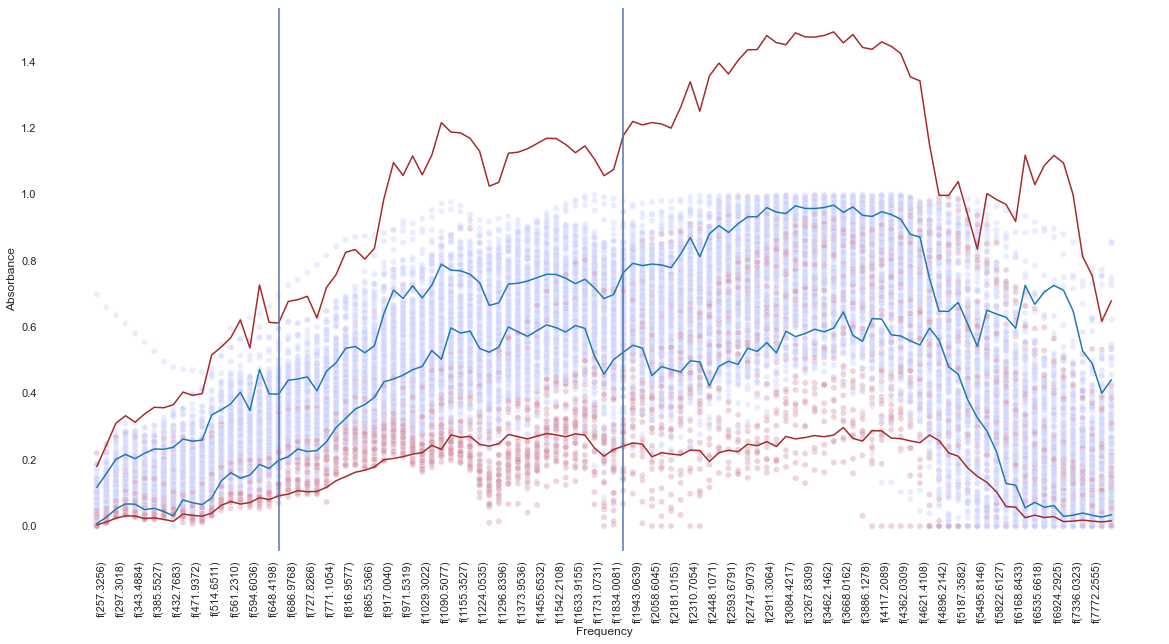

In [783]:
# colors = ["#003366", "#003366"]# Set your custom color palette
# sns.set_palette(sns.color_palette(colors))
# sns.reset_defaults()
sns.set(rc={'figure.figsize':(20,10)})
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='black'


ax = sns.lineplot(data=normative_df_long,
                    x='Frequency', y='Absorbance', 
                    hue='Limit', 
                    palette= ["tab:blue", "tab:blue"],
                    legend=None,
                    ci = None)

ax = sns.lineplot(data=normative_df_long,
                    x='Frequency', y='Leeway Limit', 
                    hue='Limit',
                    palette= ["brown", "brown"],
                    legend=None,
                    ci = None)

# ax.set_facecolor('white')
sns.scatterplot(data = freqs_long, x='Frequency', y='Absorbance', hue='OverallPoF',
                    palette = ["#cdd2ff", "#d794aa"],
                    legend = None,
                    alpha = 0.4)

# ax.fill_betweenx(0,0.2) 
plt.setp(ax.get_xticklabels()[::1], visible=True, rotation=90, ha="right")
plt.setp(ax.get_xticklabels()[::2], visible=False, rotation=40, ha="right")
plt.show;
# plt.legend(title='', loc='upper left', labels=['Lower Limit', 'Upper Limit', 'Anomalous', 'Normative'])

plt.axvline(freqs[0])
plt.axvline(freqs[-1])
# plt.axvline([freqs[-1]])
# sns.lineplot(legend=None)

## Reconstruction Error Threshold

* Used trained model to generate synthetic observations from the original data
* Calculate loss (currently using MSE loss) for each generated observation
* Keep a list of all loss values
    * We will consider an observation anomalous if the reconstruction loss is above some threshold
    * Determine the appropriate threshold by iterating through different thresholds and calculating the performance metric (currently accuracy) for each
    * Select threshold with the highest performance metric score

### Data Transformation

Must select the relevant columns and scale the dataset before the VAE is used to predict (create reconstructions).

In [784]:
## Full data - selecting relevant columns and scaling
full_scaled = pd.DataFrame(scaler.transform(full_data[X.columns]), columns = X.columns)
full_scaled = full_scaled[X_train_scaled.columns]

## Separating fails and passes (for testing purposes)
# Filter out fails
X_fails = full_scaled[full_scaled['OverallPoF'] == 1]

# Filter out passes
X_passes = full_scaled[full_scaled['OverallPoF'] == 0]

# Select relevant columns
X_fails = X_fails[X_train_scaled.columns]

X_passes = X_passes[X_train_scaled.columns]

### Create Variational Reconstructions

`vae.predict(df)` -- Creates variational reconstructions (synthetic observation) of every row of df (assuming same columns as the training set).

In [785]:
# Creating synthetic observations
full_data_pred = pd.DataFrame(vae.predict(full_scaled),columns=X_train_scaled.columns)
full_data_pred_unscaled = pd.DataFrame(scaler.inverse_transform(full_data_pred), columns = X_train_scaled.columns)
full_data_pred_unscaled.head()

8/8 [==============================] - 0s 13ms/step


AgeY        TPP       OAE1     OAE1.4       OAE2     OAE2.8       OAE4  \
0  8.620768 -13.359882  13.582298  14.567173  12.698263  11.174450  12.100764   
1  9.068849 -18.350086  13.152122  16.274858  16.432142  12.705199  12.843434   
2  9.301909 -29.899553  10.608051  17.097328  15.324933  10.664098  13.329047   
3  9.000969 -13.986948  14.454861  17.608747  14.331219  12.991179  12.280947   
4  9.359090 -16.034517  11.139078  19.455320  15.469058  11.665696  11.968380   

   Pressure        SC       ECV  ...  f(6168.8433)  f(6349.6042)  \
0 -2.965064  1.205361  1.152865  ...      0.337657      0.317205   
1 -2.373238  1.373673  1.026265  ...      0.266341      0.250477   
2 -2.996671  1.742416  1.259960  ...      0.504121      0.403959   
3 -3.325512  1.396748  1.031242  ...      0.252559      0.229734   
4 -1.688377  1.427677  1.110474  ...      0.334043      0.252815   

   f(6535.6618)  f(6727.1713)  f(6924.2925)  f(7127.1897)  f(7336.0323)  \
0      0.323810      0.329216      0.322593      0.266116      0.246374   
1      0.245978      0.246745      0.247031      0.212387      0.177184   
2      0.368850      0.378260      0.462995      0.428609      0.311827   
3      0.208338      0.191446      0.206083      0.175793      0.152242   
4      0.220182      0.182752      0.259456      0.231715      0.170701   

   f(7550.9945)  f(7772.2555)  f(8000.0000)  
0      0.213657      0.223477      0.176255  
1      0.164273      0.157240      0.145415  
2      0.303510      0.243689      0.245095  
3      0.141223      0.122625      0.116640  
4      0.182148      0.135911      0.125219  

[5 rows x 121 columns]

For every row of the synthetic dataset, calculate the loss (MSE).

In [786]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


mse_list = []
for idx, row in full_data_pred.iterrows():
    # true = X_passes_scaled.iloc[[idx]].squeeze()
    true = full_scaled.iloc[[idx]].squeeze()
    mse = mean_squared_error(row, true)
    mse_list.append(mse)
    # print(mse)


### Calculating Optimal Threshold

We will consider observations anomalous if their reconstruction errors lie outside of the Xth percentile (threshold) of reconstruction errors.\
Iterating through different thresholds (75% to 95%) to see what gives the highest accuracy.

In [787]:
label_anomalies = full_data['OverallPoF'] == 1
top_acc = 0
top_thresh = 0
for thresh in range(75, 95, 1):
    thresh = thresh/100
    error_thresh = np.quantile(mse_list, thresh)

    pred_anomalies = (mse_list > error_thresh)
    acc = accuracy_score(label_anomalies, pred_anomalies)
    if acc > top_acc:
        top_acc = acc
        top_thresh = thresh
        print("thresh {0}: acc {1}".format(top_thresh, acc))

thresh 0.75: acc 0.8577405857740585
thresh 0.76: acc 0.8661087866108786
thresh 0.77: acc 0.8786610878661087
thresh 0.78: acc 0.8870292887029289
thresh 0.79: acc 0.891213389121339
thresh 0.8: acc 0.899581589958159
thresh 0.82: acc 0.9121338912133892
thresh 0.83: acc 0.9205020920502092
thresh 0.85: acc 0.9246861924686193
thresh 0.87: acc 0.9288702928870293


Performance metric of the best threshold (in terms of accuracy).

In [788]:
error_thresh = np.quantile(mse_list, top_thresh)
pred_anomalies = (mse_list > error_thresh)
print(classification_report(label_anomalies, pred_anomalies))

              precision    recall  f1-score   support

       False       0.94      0.98      0.96       201
        True       0.84      0.68      0.75        38

    accuracy                           0.93       239
   macro avg       0.89      0.83      0.86       239
weighted avg       0.93      0.93      0.93       239



### Visualisation

In [789]:
full_data_pred_long = full_data_pred_unscaled[['OverallPoF'] + freq_cols].copy(deep=True)
full_data_pred_long['pred'] = pred_anomalies
full_data_pred_long = full_data_pred_long.melt('pred')
full_data_pred_long.columns = ['pred', 'Frequency', 'Absorbance']
full_data_pred_long.head()

pred   Frequency  Absorbance
0   True  OverallPoF    0.236096
1  False  OverallPoF    0.132593
2  False  OverallPoF    0.312517
3  False  OverallPoF    0.091223
4  False  OverallPoF    0.098335

<ipython-input-790-dd5b8c5c099b>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


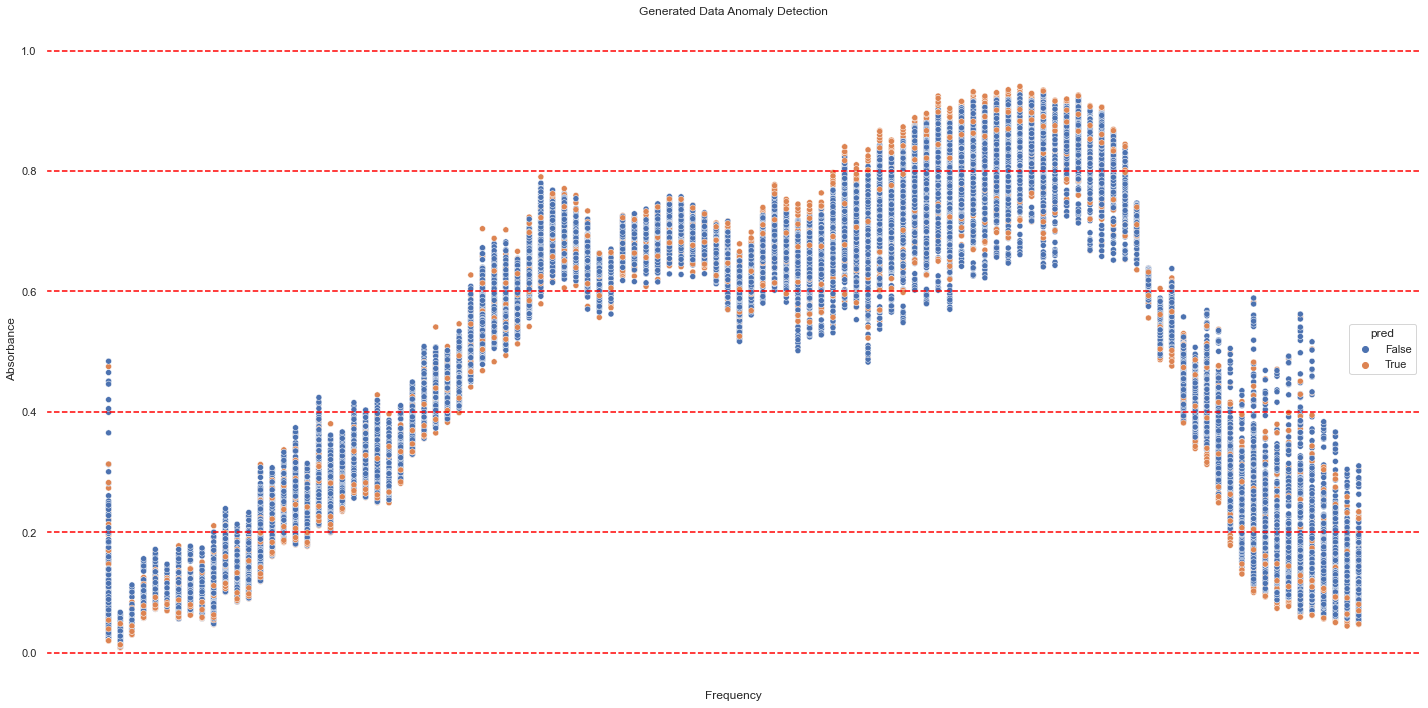

In [790]:
ax = sns.scatterplot(data = full_data_pred_long, x='Frequency', y='Absorbance', hue='pred')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Generated Data Anomaly Detection")

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

In [791]:
freqs_long['pred'] = full_data_pred_long['pred']

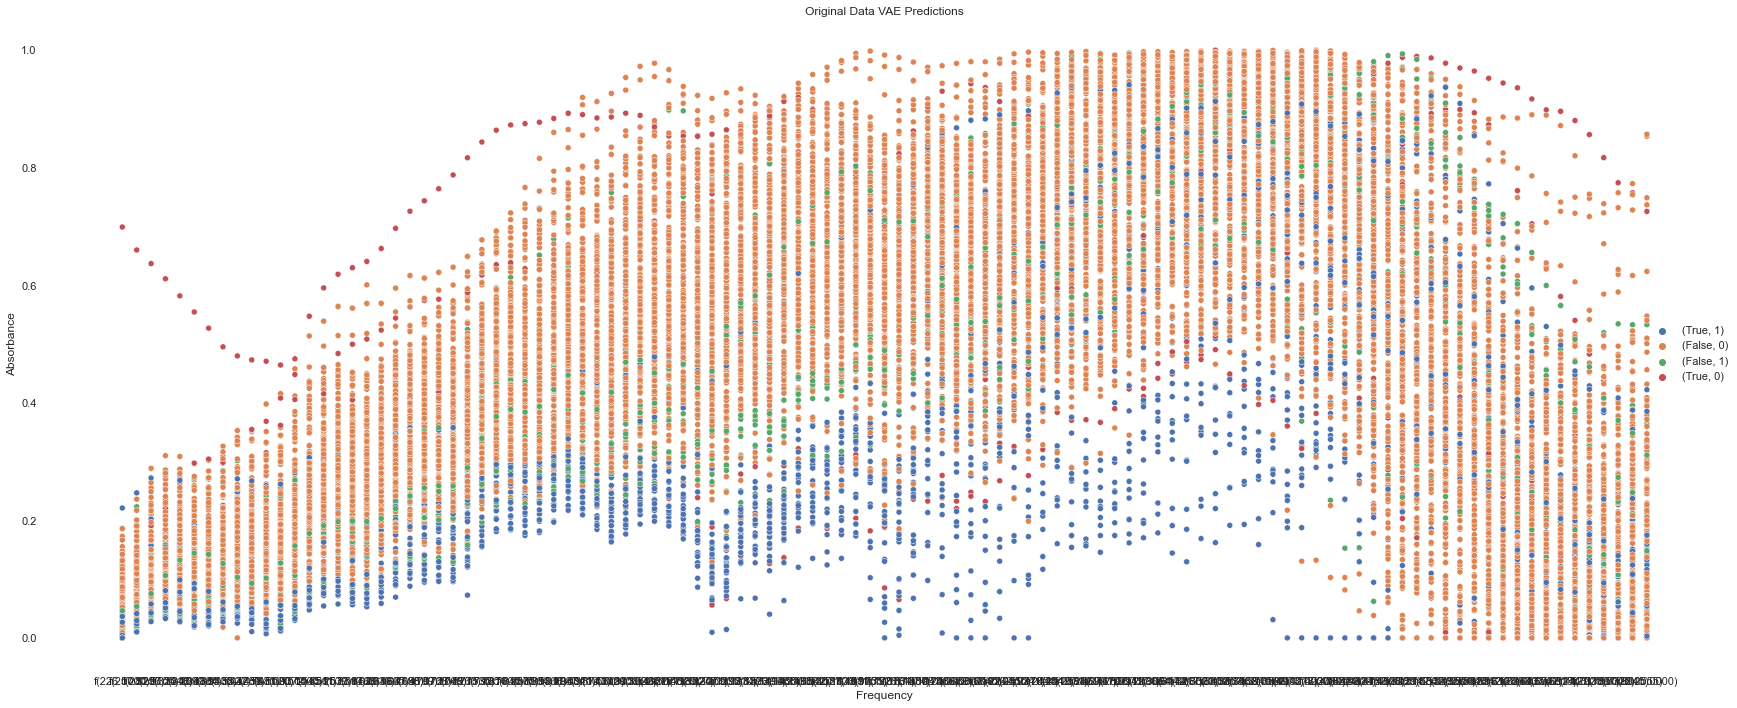

In [792]:
# ax = sns.scatterplot(data = freqs_long, x='Frequency', y='Absorbance', hue=['pred','OverallPoF'])
## CHANGE COLOURS
ax = sns.relplot(x='Frequency', y='Absorbance', data=freqs_long,
            hue=freqs_long[['pred', 'OverallPoF']].apply(tuple, axis=1),
            height=10, aspect=2.3, facet_kws={'legend_out': True})
ax.set(title="Original Data VAE Predictions")

# ax._legend.set_title('Prediction')
# # replace labels
# new_labels = ['TP', 'TN', 'FN', 'FP']
# for t, l in zip(ax._legend.texts, new_labels):
#     t.set_text(l)

# plt.legend(title='(Pred, Actual)',
#             labels=['TP', 'TN', 'FN', 'FP'],
#             loc='upper left')

plt.tight_layout()
plt.show()

### Making Process Functional

In [793]:
def vae_predict(df):
    """
    Test VAE model on dataframe `df`.
    Assumptions:
    - All code above run (as variables from the first section of this script are used)
    - `df` has all the required columns
    """
    ## Selecting relevant columns and scaling
    print("Scaling dataframe...")
    df_scaled = pd.DataFrame(scaler.transform(df[X.columns]), columns = X.columns)
    df_scaled = df_scaled[X_train_scaled.columns]

    # Create synthetic observations
    print("Creating synethetic observations...")
    df_pred = pd.DataFrame(vae.predict(df_scaled),columns=X_train_scaled.columns)

    # Unscaled (for visualisation)
    df_pred_unscaled = pd.DataFrame(scaler.inverse_transform(full_data_pred), columns = X_train_scaled.columns)

    # Calculate loss for each generated observation
    print("Calculating loss...")
    mse_list = []
    for idx, row in df_pred.iterrows():
        true = df_scaled.iloc[[idx]].squeeze()
        mse = mean_squared_error(row, true)
        mse_list.append(mse)

    # Calculate optimal threshold
    print("Calculating optimal threshold...")
    label_anomalies = df['OverallPoF'] == 1
    top_acc = 0
    top_thresh = 0
    for thresh in range(10, 95, 1):
        thresh = thresh/100
        error_thresh = np.quantile(mse_list, thresh)

        pred_anomalies = (mse_list > error_thresh)
        acc = accuracy_score(label_anomalies, pred_anomalies)
        if acc > top_acc:
            top_acc = acc
            top_thresh = thresh
    print("    Optimal threshold: {0}\n    Error: {1}\n    Accuracy: {2}".format(top_thresh, error_thresh, top_acc))

    print("Final performance:")
    # Use optimal threshold for prediction
    error_thresh = np.quantile(mse_list, top_thresh)
    pred_anomalies = (mse_list > error_thresh)
    print(classification_report(label_anomalies, pred_anomalies))


## Testing VAE Anomaly Detection

In [794]:
# os.chdir('/Users/benjamintan/Library/CloudStorage/OneDrive-TheUniversityofWesternAustralia/Master of Data Science/Year 2/Semester 2/CITS5553/CITS5553-Capstone-Project/Generative Models/Benjamin')

### Reading in Data

In [795]:
## SMOTE
X_train_smote = pd.read_csv('./Sampling/Smote Large/X_train_smote.csv')
y_train_smote = pd.read_csv('./Sampling/Smote Large/y_train_smote.csv')
X_test_smote = pd.read_csv('./Sampling/Smote Large/X_test_smote.csv')
y_test_smote = pd.read_csv('./Sampling/Smote Large/y_test_smote.csv')

train_df_smote = pd.concat([X_train_smote, y_train_smote], axis=1)
test_df_smote = pd.concat([X_test_smote, y_test_smote], axis=1)
full_smote = pd.concat([train_df_smote, test_df_smote], axis=0)

## Oversampling
X_train_over = pd.read_csv('./Sampling/Oversampling Large/X_train_over.csv')
y_train_over = pd.read_csv('./Sampling/Oversampling Large/y_train_over.csv')
X_test_over = pd.read_csv('./Sampling/Oversampling Large/X_test_over.csv')
y_test_over = pd.read_csv('./Sampling/Oversampling Large/y_test_over.csv')

train_df_over = pd.concat([X_train_over, y_train_over], axis=1)
test_df_over = pd.concat([X_test_over, y_test_over], axis=1)
full_over = pd.concat([train_df_over, test_df_over], axis=0)


## ADASYN
X_train_adasyn = pd.read_csv('./Sampling/Adasyn Large/X_train_adasyn.csv')
y_train_adasyn = pd.read_csv('./Sampling/Adasyn Large/y_train_adasyn.csv')
X_test_adasyn = pd.read_csv('./Sampling/Adasyn Large/X_test_adasyn.csv')
y_test_adasyn = pd.read_csv('./Sampling/Adasyn Large/y_test_adasyn.csv')

train_df_adasyn = pd.concat([X_train_adasyn, y_train_adasyn], axis=1)
test_df_adasyn = pd.concat([X_test_adasyn, y_test_adasyn], axis=1)
full_adasyn = pd.concat([train_df_adasyn, test_df_adasyn], axis=0)


### Original Data

In [796]:
vae_predict(full_data)

Scaling dataframe...
Creating synethetic observations...
8/8 [==============================] - 0s 11ms/step
Calculating loss...
Calculating optimal threshold...
    Optimal threshold: 0.87
    Error: 0.3375692026689536
    Accuracy: 0.9288702928870293
Final performance:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96       201
        True       0.84      0.68      0.75        38

    accuracy                           0.93       239
   macro avg       0.89      0.83      0.86       239
weighted avg       0.93      0.93      0.93       239



### Oversampling Data (Large)

In [797]:
# train_df_over['OverallPoF'].value_counts()
# test_df_over['OverallPoF'].value_counts()
full_over['OverallPoF'].value_counts()

1    5000
0    5000
Name: OverallPoF, dtype: int64

In [798]:
vae_predict(full_over)

Scaling dataframe...
Creating synethetic observations...
313/313 [==============================] - 3s 8ms/step
Calculating loss...
Calculating optimal threshold...
    Optimal threshold: 0.55
    Error: 0.5059055765211016
    Accuracy: 0.867
Final performance:
              precision    recall  f1-score   support

       False       0.83      0.92      0.87      5000
        True       0.91      0.82      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### SMOTE Data (Large)

In [799]:
# train_df_smote['OverallPoF'].value_counts()
# test_df_smote['OverallPoF'].value_counts()
full_smote['OverallPoF'].value_counts()

1    5000
0    5000
Name: OverallPoF, dtype: int64

In [800]:
vae_predict(full_smote)

Scaling dataframe...
Creating synethetic observations...
313/313 [==============================] - 2s 8ms/step
Calculating loss...
Calculating optimal threshold...
    Optimal threshold: 0.53
    Error: 0.4621765676669951
    Accuracy: 0.8886
Final performance:
              precision    recall  f1-score   support

       False       0.87      0.92      0.89      5000
        True       0.91      0.86      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### ADASYN (Large)

In [801]:
# train_df_adasyn['OverallPoF'].value_counts()
full_adasyn['OverallPoF'].value_counts()

1    5002
0    5001
Name: OverallPoF, dtype: int64

In [802]:
vae_predict(full_adasyn)

Scaling dataframe...
Creating synethetic observations...
313/313 [==============================] - 3s 9ms/step
Calculating loss...
Calculating optimal threshold...
    Optimal threshold: 0.41
    Error: 0.40278909429780513
    Accuracy: 0.6367089873038089
Final performance:
              precision    recall  f1-score   support

       False       0.67      0.55      0.60      5001
        True       0.62      0.73      0.67      5002

    accuracy                           0.64     10003
   macro avg       0.64      0.64      0.63     10003
weighted avg       0.64      0.64      0.63     10003



In [803]:
len(X_train_scaled.columns)

121

# Latent Dimension Visualisation

## Pre-Processing

In [804]:
fails = full_data[X_train_scaled.columns]
fails_scaled = pd.DataFrame(scaler.transform(fails), columns = X_train_scaled.columns)
fails_scaled = fails_scaled[fails_scaled['OverallPoF'] == 1]

passes = full_data[X_train_scaled.columns]
passes_scaled = pd.DataFrame(scaler.transform(passes), columns = X_train_scaled.columns)
passes_scaled = passes_scaled[passes_scaled['OverallPoF'] == 0]


In [812]:
len(fails_scaled)

38

In [811]:
if latent_dim == 2:
    zlist = []
    n_samples = 1000
    sample_fail = 5
    sample_pass = 4
    
    # first n samples: passes 
    for i in range(n_samples):
        lat_dim = encoder.predict(passes_scaled.iloc[[sample_pass]])
        zlist.append(lat_dim[2])
    
    # next n samples: fails
    for i in range(n_samples):
        lat_dim = encoder.predict(fails_scaled.iloc[[sample_fail]])
        zlist.append(lat_dim[2])

1/1 [==============================] - 0s 13ms/step


In [814]:
if latent_dim == 2:
    latent_dict = {
        'dim1':[],
        'dim2':[],

        'OverallPoF':[]
    }
    for dim in zlist[:n]:
        latent_dict['dim1'].append(float(dim[:,0]))
        latent_dict['dim2'].append(float(dim[:,1]))
        latent_dict['OverallPoF'].append(0)
    for dim in zlist[n:]:
        latent_dict['dim1'].append(float(dim[:,0]))
        latent_dict['dim2'].append(float(dim[:,1]))
        latent_dict['OverallPoF'].append(1)
    
    latent_df = pd.DataFrame(latent_dict)


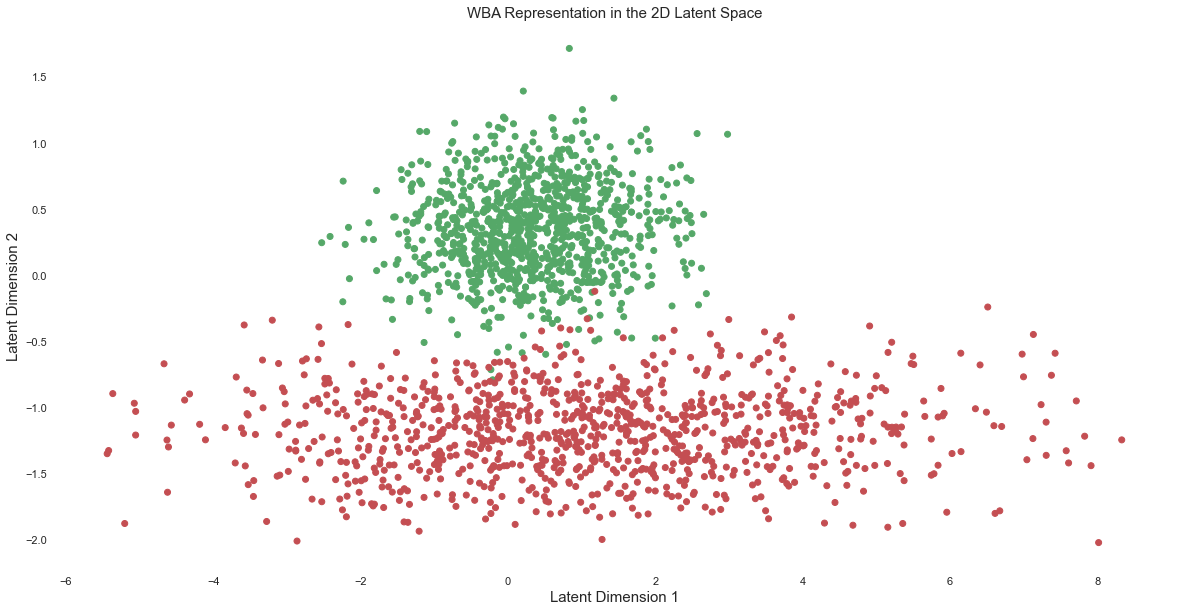

In [815]:
if latent_dim == 2:
    fig, ax = plt.subplots()
    # encoder returns 3 arrays, z-mean, z-log-sigma, z 
    scatter = ax.scatter(
        latent_df['dim1'],
        latent_df['dim2'],
        c=latent_df['OverallPoF'].map(colours)
                        )

    ax.set_xlabel("Latent Dimension 1", fontsize = 15)
    ax.set_ylabel("Latent Dimension 2", fontsize = 15)
    ax.set_title("Latent Space of 1 Fail and 1 Pass Samples {} Times Each".format(n_samples), fontsize = 15)
    # ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
    plt.show();